In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

from sklearn.neighbors import NearestNeighbors

In [3]:
# Elegimos la semilla
np.random.seed(263) # últimos tres dígitos del DNI

# Número de observaciones
n = 5000

# Generamos las edades para tratamiento y control
edad_tratamiento = np.random.normal(20, 2.5, int(n / 2))
edad_control = np.random.normal(25, 3, int(n / 2))
edad = np.concatenate((edad_tratamiento, edad_control))

# Generamos la experiencia para tratamiento y control
exper_tratamiento = np.random.normal(1.76, 0.5, int(n / 2))
exper_control = np.random.normal(2.3, 0.75, int(n / 2))
exper = np.concatenate((exper_tratamiento, exper_control))

# Variables centradas con respecto a la media
edad_c = edad - edad.mean()
exper_c = exper - exper.mean()

# Variables al cuadrado
edad_c2 = edad_c ** 2
exper_c2 = exper_c ** 2

# Producto cruzado
edadexper = edad_c * exper_c

# Variable de tratamiento
tratamiento = np.concatenate((np.ones(int(n / 2)), np.zeros(int(n / 2))))

# Error aleatorio
epsilon = np.random.normal(0, 0.5, n)

# Resultados potenciales
y0 = 15000 + 10.25 * edad_c + 10.5 * edad_c2 + 1000 * exper_c - 10.5 * exper_c2 + 500 * edadexper + epsilon
y1 = y0 + 2500 + 100 * edad_c + 1000 * exper_c

# Verdadero ATE y ATT
ate_verdadero = np.mean(y1 - y0)
att_verdadero = np.mean((y1 - y0)[tratamiento == 1])

print(f'El verdadero ATE es: {ate_verdadero:.2F}')
print(f'El verdadero ATT es: {att_verdadero:.2F}')

El verdadero ATE es: 2500.00
El verdadero ATT es: 1999.77


### Modelo 1

In [16]:
# Listas para almacenar el resultado de las simulaciones
att_resultados_m1 = []

# Elegimos la semilla
np.random.seed(263) # últimos tres dígitos del DNI

# Realizamos las simulaciones
simulaciones = 1000

for _ in range(simulaciones):

    # Nùmero de observaciones
    n = 5000

    # Generamos las edades para tratamiento y control
    edad_tratamiento = np.random.normal(20, 2.5, int(n / 2))
    edad_control = np.random.normal(25, 3, int(n / 2))
    edad = np.concatenate((edad_tratamiento, edad_control))

    # Generamos la experiencia para tratamiento y control
    exper_tratamiento = np.random.normal(1.76, 0.5, int(n / 2))
    exper_control = np.random.normal(2.3, 0.75, int(n / 2))
    exper = np.concatenate((exper_tratamiento, exper_control))

    # Variables centradas con respecto a la media
    edad_c = edad - edad.mean()
    exper_c = exper - exper.mean()

    # Variables al cuadrado
    edad_c2 = edad_c ** 2
    exper_c2 = exper_c ** 2

    # Producto cruzado
    edadexper = edad_c * exper_c

    # Variable de tratamiento
    tratamiento = np.concatenate((np.ones(int(n / 2)), np.zeros(int(n / 2))))

    # Error aleatorio
    epsilon = np.random.normal(0, 0.5, n)

    # Resultados potenciales
    y0 = 15000 + 10.25 * edad_c + 10.5 * edad_c2 + 1000 * exper_c - 10.5 * exper_c2 + 500 * edadexper + epsilon
    y1 = y0 + 2500 + 100 * edad_c + 1000 * exper_c

    ###############################################################################
    # Modelo 1
    ym1 = y1 * tratamiento + y0 * (1 - tratamiento)

    # Datos
    data = pd.DataFrame({'y': ym1, 'tratamiento': tratamiento, 'edad_c': edad_c, 'exper_c': exper_c})

    # Separar datos de tratamiento y control
    data_tratamiento = data[data['tratamiento'] == 1]
    data_control = data[data['tratamiento'] == 0]

    # Variables para emparejamiento
    variables_tratamiento = data_tratamiento[['edad_c', 'exper_c']]
    variables_control = data_control[['edad_c', 'exper_c']]
    cov_matrix = np.cov(variables_control.T) # Para la distancia de Mahalanobis

    # Nearest Neighbors para encontrar el emparejamiento minimizando la distancia de Mahalanobis
    nn = NearestNeighbors(n_neighbors=1, algorithm='ball_tree', metric='mahalanobis', metric_params={'V': cov_matrix})
    nn.fit(variables_control)
    distances, indices = nn.kneighbors(variables_tratamiento)

    # Obtener los individuos emparejados
    matched_control = data_control.iloc[indices.flatten()]

    # Aplicar el estimador de Abadie e Imbens para obtener el ATT ajustado
    model1 = sm.OLS.from_formula('y ~ tratamiento', data=data)
    resultados = model1.fit()
    att_abadie_imbens = resultados.params['tratamiento']

    att_resultados_m1.append(att_abadie_imbens)

att_promedio_m1 = np.mean(att_resultados_m1)
print(f'ATT promedio: {att_promedio_m1:.2f}')

ATT promedio: 1362.54


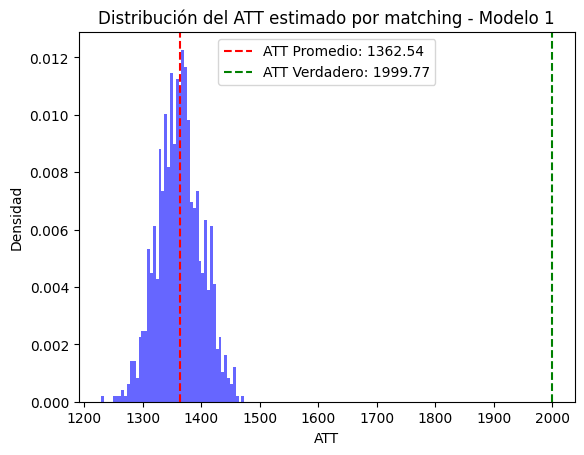

In [17]:
# Gráfico de densidad para el modelo 1
plt.hist(att_resultados_m1, bins=50, density=True, alpha=0.6, color='b')
plt.axvline(x=att_promedio_m1, color='red', linestyle='--', label=f'ATT Promedio: {att_promedio_m1:.2f}')
plt.axvline(x=att_verdadero, color='green', linestyle='--', label=f'ATT Verdadero: {att_verdadero:.2f}')
plt.xlabel('ATT')
plt.ylabel('Densidad')
plt.title('Distribución del ATT estimado por matching - Modelo 1')
plt.legend()
plt.show()

### Modelo 2

In [18]:
# Listas para almacenar el resultado de las simulaciones
att_resultados_m2 = []

# Elegimos la semilla
np.random.seed(263) # últimos tres dígitos del DNI

# Realizamos las simulaciones
simulaciones = 1000

for _ in range(simulaciones):

    # Nùmero de observaciones
    n = 5000

    # Generamos las edades para tratamiento y control
    edad_tratamiento = np.random.normal(20, 2.5, int(n / 2))
    edad_control = np.random.normal(25, 3, int(n / 2))
    edad = np.concatenate((edad_tratamiento, edad_control))

    # Generamos la experiencia para tratamiento y control
    exper_tratamiento = np.random.normal(1.76, 0.5, int(n / 2))
    exper_control = np.random.normal(2.3, 0.75, int(n / 2))
    exper = np.concatenate((exper_tratamiento, exper_control))

    # Variables centradas con respecto a la media
    edad_c = edad - edad.mean()
    exper_c = exper - exper.mean()

    # Variables al cuadrado
    edad_c2 = edad_c ** 2
    exper_c2 = exper_c ** 2

    # Producto cruzado
    edadexper = edad_c * exper_c

    # Variable de tratamiento
    tratamiento = np.concatenate((np.ones(int(n / 2)), np.zeros(int(n / 2))))

    # Error aleatorio
    epsilon = np.random.normal(0, 0.5, n)

    # Resultados potenciales
    y0 = 15000 + 10.25 * edad_c + 10.5 * edad_c2 + 1000 * exper_c - 10.5 * exper_c2 + 500 * edadexper + epsilon
    y1 = y0 + 2500 + 100 * edad_c + 1000 * exper_c

    ###############################################################################
    # Modelo 2
    ym2 = y1 * tratamiento + y0 * (1 - tratamiento)

    # Datos
    data = pd.DataFrame({'y': ym2, 'tratamiento': tratamiento, 'edad_c': edad_c, 'exper_c': exper_c})

    # Separar datos de tratamiento y control
    data_tratamiento = data[data['tratamiento'] == 1]
    data_control = data[data['tratamiento'] == 0]

    # Variables para emparejamiento
    variables_tratamiento = data_tratamiento[['edad_c', 'exper_c']]
    variables_control = data_control[['edad_c', 'exper_c']]
    cov_matrix = np.cov(variables_control.T) # Para la distancia de Mahalanobis

    # Nearest Neighbors para encontrar el emparejamiento minimizando la distancia de Mahalanobis
    nn = NearestNeighbors(n_neighbors=1, algorithm='ball_tree', metric='mahalanobis', metric_params={'V': cov_matrix})
    nn.fit(variables_control)
    distances, indices = nn.kneighbors(variables_tratamiento)

    # Obtener los individuos emparejados
    matched_control = data_control.iloc[indices.flatten()]

    # Aplicar el estimador de Abadie e Imbens para obtener el ATT ajustado que corrige por sesgo
    model2 = sm.OLS.from_formula('y ~ tratamiento', data=data)
    resultados = model2.fit(cov_type='nonrobust')  # HC3 corrige por sesgo 
    att_abadie_imbens = resultados.params['tratamiento']

    att_resultados_m2.append(att_abadie_imbens)

att_promedio_m2 = np.mean(att_resultados_m2)
print(f'ATT promedio: {att_promedio_m2:.2f}')

ATT promedio: 1362.54


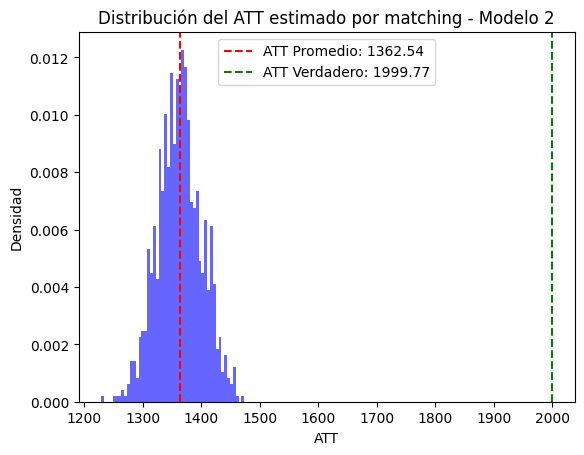

In [19]:
# Gráfico de densidad para el modelo 2
plt.hist(att_resultados_m2, bins=50, density=True, alpha=0.6, color='b')
plt.axvline(x=att_promedio_m2, color='red', linestyle='--', label=f'ATT Promedio: {att_promedio_m2:.2f}')
plt.axvline(x=att_verdadero, color='green', linestyle='--', label=f'ATT Verdadero: {att_verdadero:.2f}')
plt.xlabel('ATT')
plt.ylabel('Densidad')
plt.title('Distribución del ATT estimado por matching - Modelo 2')
plt.legend()
plt.show()

### Modelo 3

In [22]:
# Listas para almacenar el resultado de las simulaciones
att_resultados_m3 = []

# Elegimos la semilla
np.random.seed(263) # últimos tres dígitos del DNI

# Realizamos las simulaciones
simulaciones = 1000

for _ in range(simulaciones):

    # Nùmero de observaciones
    n = 5000

    # Generamos las edades para tratamiento y control
    edad_tratamiento = np.random.normal(20, 2.5, int(n / 2))
    edad_control = np.random.normal(25, 3, int(n / 2))
    edad = np.concatenate((edad_tratamiento, edad_control))

    # Generamos la experiencia para tratamiento y control
    exper_tratamiento = np.random.normal(1.76, 0.5, int(n / 2))
    exper_control = np.random.normal(2.3, 0.75, int(n / 2))
    exper = np.concatenate((exper_tratamiento, exper_control))

    # Variables centradas con respecto a la media
    edad_c = edad - edad.mean()
    exper_c = exper - exper.mean()

    # Variables al cuadrado
    edad_c2 = edad_c ** 2
    exper_c2 = exper_c ** 2

    # Producto cruzado
    edadexper = edad_c * exper_c

    # Variable de tratamiento
    tratamiento = np.concatenate((np.ones(int(n / 2)), np.zeros(int(n / 2))))

    # Error aleatorio
    epsilon = np.random.normal(0, 0.5, n)

    # Resultados potenciales
    y0 = 15000 + 10.25 * edad_c + 10.5 * edad_c2 + 1000 * exper_c - 10.5 * exper_c2 + 500 * edadexper + epsilon
    y1 = y0 + 2500 + 100 * edad_c + 1000 * exper_c

    ###############################################################################
    # Modelo 1
    ym3 = y1 * tratamiento + y0 * (1 - tratamiento)

    # Datos
    data = pd.DataFrame({'y': ym3, 'tratamiento': tratamiento, 'edad_c': edad_c, 'edad_c2': edad_c2,
                         'exper_c': exper_c, 'exper_c2': exper_c2, 'edadexper': edadexper})

    # Separar datos de tratamiento y control
    data_tratamiento = data[data['tratamiento'] == 1]
    data_control = data[data['tratamiento'] == 0]

    # Variables para emparejamiento
    variables_tratamiento = data_tratamiento[['edad_c', 'edad_c2', 'exper_c', 'exper_c2', 'edadexper']]
    variables_control = data_control[['edad_c', 'edad_c2', 'exper_c', 'exper_c2', 'edadexper']]
    cov_matrix = np.cov(variables_control.T) # Para la distancia de Mahalanobis

    # Nearest Neighbors para encontrar el emparejamiento minimizando la distancia de Mahalanobis
    nn = NearestNeighbors(n_neighbors=1, algorithm='ball_tree', metric='mahalanobis', metric_params={'V': cov_matrix})
    nn.fit(variables_control)
    distances, indices = nn.kneighbors(variables_tratamiento)

    # Obtener los individuos emparejados
    matched_control = data_control.iloc[indices.flatten()]

    # Aplicar el estimador de Abadie e Imbens para obtener el ATT ajustado
    model3 = sm.OLS.from_formula(ym3, data=data)
    resultados = model3.fit()
    att_abadie_imbens = resultados.params['tratamiento']

    att_resultados_m3.append(att_abadie_imbens)

att_promedio_m3 = np.mean(att_resultados_m3)
print(f'ATT promedio: {att_promedio_m3:.2f}')

PatsyError: model is missing required outcome variables